In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

if not torch.backends.mps.is_available():
    device = torch.device('cpu')
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")

# Basic block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64  # Change the initial in_planes to 64 for ResNet-34

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 3 input channels for RGB images
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(35840 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

# Create a ResNet-34 model
resnet34 = ResNet34()


In [2]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

resize_scale = 0.5

def custom_transform(image):
    # Crop the image to the desired region of interest (ROI)
    image = image.crop((55, 35, 390, 253))
    # Convert the cropped image to a PyTorch tensor
    return transforms.ToTensor()(image)

def load_data(resize_images = False):
    # Define your data transformation (without resizing)
    transforms_list = []
    transforms_list.append(transforms.Grayscale(num_output_channels=1))
    transforms_list.append(transforms.Lambda(custom_transform))  # Apply the custom transformation
    if resize_images:
        transforms_list.append(transforms.Resize((int(218*resize_scale), int(335*resize_scale))))
    transforms_list.append(transforms.Normalize((0.5,), (0.5,)))  # Normalize to [-1, 1]
    data_transform = transforms.Compose(transforms_list)

    class CustomImageDataset(datasets.ImageFolder):
        def __init__(self, root, transform=None):
            super(CustomImageDataset, self).__init__(root=root, transform=transform)

    # Define the path to your data folder
    data_dir = 'data/images_original'

    # Create an instance of your custom dataset
    custom_dataset = CustomImageDataset(root=data_dir, transform=data_transform)

    # Calculate the size of the training and testing sets
    total_size = len(custom_dataset)
    train_size = int(0.8 * total_size)
    test_size = total_size - train_size

    # Split the dataset
    train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])
    batch_size = 10  # You can adjust this batch size as needed

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_data(resize_images=False)

# Get a batch of data from the training loader
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

print("Image shape:", images[0].shape)
num_channels = images[0].shape[0]  # The number of channels in the image
print("Number of channels:", num_channels)

/Users/steven/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Image shape: torch.Size([1, 218, 335])
Number of channels: 1


In [28]:
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from fastai.vision.all import vision_learner
import torch.optim as optim

data = DataLoaders(train_loader, test_loader)

net = ResNet34()
net.to(device)

learn = vision_learner(data, net, opt_func=optim.SGD, loss_func=nn.CrossEntropyLoss)
# Create an optimizer
optimizer = optim.SGD(net.parameters(), lr=1e-6, momentum=0.9)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification

# Use the lr_find method to find the optimal learning rate
learn.lr_find()

# Plot the learning rate vs. loss
learn.recorder.plot_lr_find()

# Get the best learning rate
optimal_lr = learn.recorder.opt_lr
print(f"Optimal Learning Rate: {optimal_lr}")

AssertionError: `n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`

/var/folders/29/yzpf4dbd3n19bxxhqjb8d35c0000gn/T/ipykernel_76375/1209740582.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).to(device)


Step 1/50 | Learning Rate: 1e-07 | Loss: 2.3793793976306916
Step 2/50 | Learning Rate: 1.325711365590109e-07 | Loss: 2.4180063366889955
Step 3/50 | Learning Rate: 1.757510624854792e-07 | Loss: 2.3249068677425386
Step 4/50 | Learning Rate: 2.3299518105153724e-07 | Loss: 2.4409017086029055
Step 5/50 | Learning Rate: 3.0888435964774815e-07 | Loss: 2.382727861404419
Step 6/50 | Learning Rate: 4.0949150623804263e-07 | Loss: 2.286770886182785
Step 7/50 | Learning Rate: 5.428675439323862e-07 | Loss: 2.4711249470710754
Step 8/50 | Learning Rate: 7.196856730011523e-07 | Loss: 2.3150293111801146
Step 9/50 | Learning Rate: 9.540954763499942e-07 | Loss: 2.213531565666199
Step 10/50 | Learning Rate: 1.2648552168552967e-06 | Loss: 2.3238751173019407
Step 11/50 | Learning Rate: 1.676832936811009e-06 | Loss: 2.3450255751609803
Step 12/50 | Learning Rate: 2.222996482526196e-06 | Loss: 2.237525773048401
Step 13/50 | Learning Rate: 2.9470517025518124e-06 | Loss: 2.239734035730362
Step 14/50 | Learning Ra

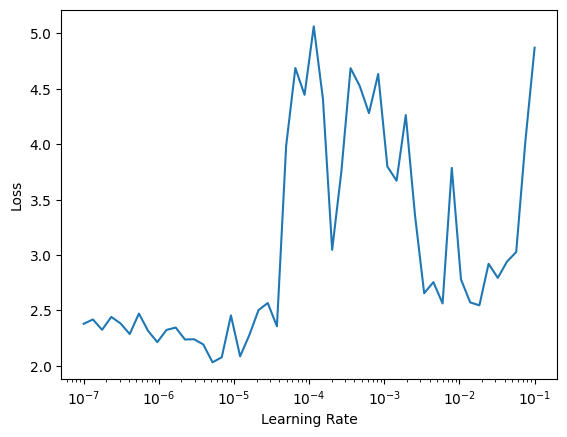

Optimal Learning Rate: 5.179474679231214e-06


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import random
import math

# Define your neural network
net = ResNet34()  # Replace with your ResNet34 implementation
net.to(device)

# Define the loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()

start_lr = 1e-7  # Lower starting learning rate
end_lr = 0.1  # Wider range
num_steps = 50  # Fewer steps

# Calculate the scaling factor for each step
scaling_factor = math.exp(math.log(end_lr / start_lr) / (num_steps - 1))
optimizer = optim.SGD(net.parameters(), lr=start_lr, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=start_lr)
lr_lambda = lambda step: (scaling_factor ** step)
scheduler = LambdaLR(optimizer, lr_lambda)

# Lists to store learning rates and losses
learning_rates = []
losses = []

# Set the number of training iterations for each learning rate step
num_iterations = 2  # A small number of minibatches

# Counter to keep track of the current step
step_counter = 0

# Learning rate range test loop
for step in range(num_steps):
    # Set the learning rate using the scheduler
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    running_loss = 0.0

    # Create a random subset from the training dataset
    random_subset = random.sample(range(len(train_loader.dataset)), num_iterations * train_loader.batch_size)

    for i in random_subset:
        inputs, labels = train_loader.dataset[i]  # Assuming a tuple structure

        # Convert inputs and labels to tensors and move to device
        inputs = torch.tensor(inputs).to(device)
        labels = torch.tensor(labels).to(device)

        optimizer.zero_grad()
        outputs = net(inputs.unsqueeze(0))
        loss = criterion(outputs, labels.unsqueeze(0))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Record the loss for this step
    losses.append(running_loss / (num_iterations * train_loader.batch_size))

    # Increment the step counter
    step_counter += 1

    # Update the learning rate
    scheduler.step()

    print(f"Step {step_counter}/{num_steps} | Learning Rate: {current_lr} | Loss: {running_loss / (num_iterations * train_loader.batch_size)}")

# Plot the learning rate vs. loss curve
plt.plot(learning_rates, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

# Find the optimal learning rate
optimal_lr = learning_rates[losses.index(min(losses))]
print(f"Optimal Learning Rate: {optimal_lr}")

In [42]:
import torch.nn as nn
import torch.optim as optim

# Define your neural network
net = ResNet34()
net.to(device)

# Define the loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.SGD(net.parameters(), lr=0.0003, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=start_lr)

# Set the number of training epochs
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0

    # Iterate over the training dataset
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    # Evaluate the model on the test dataset and calculate accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1} | Loss: {running_loss:.3f} | Accuracy: {test_accuracy:.2f}%")

print("Training finished")

# Save the trained model if desired
# torch.save(net.state_dict(), "my_model.pth")


Epoch 1 | Loss: 194.018 | Accuracy: 10.00%
Epoch 2 | Loss: 186.553 | Accuracy: 12.00%
Epoch 3 | Loss: 181.016 | Accuracy: 13.00%
Epoch 4 | Loss: 177.553 | Accuracy: 17.00%


KeyboardInterrupt: 

In [38]:

# scaling_factor = math.exp(math.log(end_lr / start_lr) / (num_steps - 1))
optimizer = optim.SGD(net.parameters(), lr=start_lr, momentum=0.9)
lr_lambda = lambda step: (scaling_factor ** step)

# Calculate the scaling factor for each step
# scaling_factor = math.exp(math.log(end_lr / start_lr) / (num_steps - 1))
# optimizer = optim.SGD(net.parameters(), lr=start_lr, momentum=0.9)
# lr_lambda = lambda step: (scaling_factor ** step)
# scheduler = LambdaLR(optimizer, lr_lambda)


math.exp(math.log(end_lr / start_lr)/(num_steps - 1))

for step in range(num_steps):
    print(scaling_factor**step)

1.0
1.2648552168552962
1.5998587196060585
2.023589647725158
2.5595479226995366
3.2374575428176455
4.094915062380427
5.179474679231214
6.551285568595514
8.286427728546851
10.481131341546867
13.257113655901104
16.768329368110102
21.209508879201934
26.826957952797294
33.93221771895333
42.919342601287845
54.28675439323869
68.66488450043012
86.85113737513542
109.85411419875604
138.94954943731403
175.75106248547954
222.29964825261996
281.1768697974237
355.64803062231374
449.84326689694564
568.9866029018311
719.6856730011539
910.2981779915243
1151.3953993264506
1456.348477501248
1842.0699693267215
2329.9518105153793
2947.05170255182
3727.5937203149524
4714.8663634574095
5963.623316594663
7543.120063354644
9540.954763499974
12067.926406393331
15264.179671752392
19306.97728883258
24420.530945486607
30888.435964774937
39069.399370546336
49417.133613238555
62505.51925274
79060.43210907734
100000.00000000045


49